
<div style="background-color:#000047; padding: 30px; border-radius: 10px; color: white; text-align: center;">
    <img src='Figures/alinco.png' style="height: 100px; margin-bottom: 10px;"/>
    <h1> Arboles de Decision y Bosques Aleatorios</h1>
</div>


## Arboles de Desición


Los árboles de decisión, también conocidos como modelos de árbol de clasificación y regresión (CART), son métodos basados en árboles para el aprendizaje automático supervisado. Los árboles de clasificación y de regresión simples son fáciles de usar e interpretar, pero no son competitivos con los mejores métodos de aprendizaje automático. Sin embargo, forman la base para el conjunto de modelos de ensamblaje como “bagged trees”, “random forest” y “boosted trees”, que aunque son menos interpretables, son muy precisos.

Los modelos CART se puede definir en dos tipos de problemas

**Árboles de clasificación:** la variable resultado es categórica y el métodos se utiliza para identificar la “clase” dentro de la cual es más probable que caiga nuestra variable resultado. Un ejemplo de un problema de tipo clasificación sería determinar quién se suscribirá o no a una plataforma digital; o quién se graduará o no de la escuela secundaria; o si una persona tiene cáncer o no.

**Árboles de regressión:** la variable resultado es continua y el métodos se utiliza para predecir su valor. Un ejemplo de un problema de tipo regresión sería predecir los precios de venta de una casa residencial o el nivel de colesterol de una persona.


Un árbol de decisión es una secuencia de operadores relacionales organizados como árbol donde:

- Los atributos de un dato son evaluados desde la raiz hasta las hojas
- Los nodos hoja (terminales) están asociados a una clase
- Los nodos no-hoja están asociados a un operador lógico que divide los datos en dos o más conjuntos
- El operador lógico o *split* se aplica sobre un atributo (feature) de los datos

El siguiente diagrama ejemplifica el funcionamiento del árbol de decisión sobre un dataset con dos etiquetas y dos atributos (X y Z). 

<img src="Figures/tree.png" width="600">

- La figura izquierda muestra un árbol de decisión binario con 5 nodos: 3 nodos hoja y 2 nodos de decisión.
- La figura derecha muestra la partición que produce el árbol de decisión en el espacio de los datos. 
- Las separaciones o *splits* son siempre perpendiculares a los ejes de los datos (atributos).


Entrenar el árbol de decisión es el proceso de escoger los atributos, operadores y umbrales de separación en los nodos de decisión.


La función de costo más común para los árboles de regresión es la suma de los residuos al cuadrado,

$$RSS = \sum_{k=1}^{K}\sum_{i \ in A_k} (y_i - \hat{y}_{A_k})^2$$

Para árboles de clasificación, es el índice de Gini,

$$ G=\sum_{c=1}^C \hat{p}_{kc} (1-\hat{p}_{kc})$$

y la entropía (información estadística)

$$ E= - \sum_{c=1}^C \hat{p}_{kc} log(\hat{p}_{kc})$$

dónde $\hat{p}_{kc}$ es la proporción de observaciones de entrenamiento en el nodo $k$ que son de clase $c$. Un nodo completamente puro en un árbol binario tendría $\hat{p} \in \{0,1\}$ y $G=E=0$.  Un nodo completamente impuro en un árbol binario tendría $\hat{p}=0.5$ y $G=0.5^2*2 = 0.25$, y $D=- (0.5 \cdot log(0.5))\cdot 2 = 0.69$

La ganacia de información para un nodo que separa un conjunto de datos $D$ en dos $D_{izq}$ y $D_{der}$ es

$$
G(D; D_{izq}, D_{der}) = H(D) - \frac{|D_{izq}|}{|D|} H(D_{izq}) - \frac{|D_{der}|}{|D|} H(D_{der})
$$

donde $|A|$ es la cardinalidad del subconjunto $A$ y 

$$
H(A) = - \sum_{y \in \mathcal{Y}} p(y|A) \log p(y|A)
$$

es la entropía del subconjunto $A$. En la expresión anterior $p(y|A)$ es la frecuencia relativa de los ejemplos de clase $y$ dentro de $A$.

**La entropía mide la “pureza” del subconjunto en términos de sus clases. El subconjunto más puro es aquel donde todos los elementos son de la misma clase. El nodo más impuro es aquel en donde hay igual cantidad de elementos de cada clase (uniforme).**

## Algoritmo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Sea el siguiente arreglo las etiquetas de un subconjunto de 12 ejemplos

In [2]:
labels = np.array([1,0,0,1,1,1,0,1,0,1,1,1])
labels

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

Asumiendo que el problema sólo tiene dos clases las frecuencias relativas son

In [3]:
a, counts= np.unique(labels, return_counts=True)
counts/len(labels)


array([0.33333333, 0.66666667])

Y la entropía del conjunto sería:

In [4]:
def entropy(subset_labels):
    unique, counts= np.unique(subset_labels, return_counts=True)
    frecuencias = counts/len(subset_labels)
    entropia = -np.sum(frecuencias*np.log2(frecuencias + 1e-16))
    return entropia


In [5]:
entropy(labels)

0.9182958340544893

La entropía es máxima si hay igual cantidad de ejemplos de ambas clases (mínima pureza)

In [6]:
B = np.array([1,1,1,0,0,0])
entropy(B)

0.9999999999999997

y mínima si todos los ejemplos son de una clase  (máxima pureza)

In [7]:
C = np.array([1,1,1,1,1,1])
entropy(C)

-0.0

**Extensión a más de dos clases**

Si un nodo separa el conjunto en $k$ subconjuntos la regla es


- En cada nodo se escoge el atributo que maximiza la ganancia de información.

Consideremos el siguiente problema:

In [8]:
data = {'tiempo' : ['soleado', 'soleado', 'soleado', 'lluvioso', 'lluvioso'],
        'humedad' : ['baja','baja', 'alta','alta','alta'],
        'temperatura': ['templado','caluroso', 'caluroso', 'templado', 'frio']}

nodo = pd.DataFrame(data)
nodo

,tiempo,humedad,temperatura
0,soleado,baja,templado
1,soleado,baja,caluroso
2,soleado,alta,caluroso
3,lluvioso,alta,templado
4,lluvioso,alta,frio


donde queremos obtener un árbol de decisión que prediga el tiempo en función de la humedad y de la temperatura.

Para decidir cual variable debe ir en el primer nodo comparamos sus ganancias de información

In [10]:
def info_gain(subset, feature):
    subset_labels = subset['tiempo'].values
    entropy_root = entropy(subset_labels)
    entropy_nodes = []
    for unique_label in subset[feature].unique():
        split = subset.loc[subset[feature] == unique_label]
        split_labels = split['tiempo'].values
        entropy_nodes.append(entropy(split_labels)*len(split_labels)/len(subset_labels))
    return entropy_root - sum(entropy_nodes)
    

In [11]:
for feature in ['humedad','temperatura']:
    print(f'La ganancia de información para {feature} es:{info_gain(nodo, feature)} ')

La ganancia de información para humedad es:0.4199730940219747 
La ganancia de información para temperatura es:0.5709505944546684 


Temperatura tiene mayor ganancia que humedad, por lo tanto el primer nodo separador utiliza temperatura.

Si separamos por temperatura tenemos:

In [12]:
nodo.loc[nodo['temperatura']=='frio']

,tiempo,humedad,temperatura
4,lluvioso,alta,frio


En el caso `frio` se produce un nodo con un sólo ejemplo. El algoritmo no seguirá dividiendo.

In [13]:
nodo.loc[nodo['temperatura']=='caluroso']

,tiempo,humedad,temperatura
1,soleado,baja,caluroso
2,soleado,alta,caluroso


En el caso `caluroso` se produce un nodo con "puro". El algoritmo no seguirá dividiendo.

In [14]:
nodo.loc[nodo['temperatura']=='templado']

,tiempo,humedad,temperatura
0,soleado,baja,templado
3,lluvioso,alta,templado


En el caso `templado` el nodo no es puro, debemos nuevamente escoger un atributo para separar:

In [15]:
nodo_next = nodo.loc[nodo['temperatura']=='templado']
for feature in ['temperatura', 'humedad']:
    print(f'La ganancia de información para {feature} es:{info_gain(nodo_next, feature)} ')

La ganancia de información para temperatura es:0.0 
La ganancia de información para humedad es:0.9999999999999997 


Por lo tanto se escoge humedad, lo cual produce dos nodos puros (con un sólo ejemplo)

In [16]:
nodo_next.loc[nodo_next['humedad']=='baja']

,tiempo,humedad,temperatura
0,soleado,baja,templado


In [17]:
nodo_next.loc[nodo_next['humedad']=='alta']

,tiempo,humedad,temperatura
3,lluvioso,alta,templado


El algoritmo sigue separando el dataset de forma recursiva hasta que todos los nodos sean puros o hasta que se supere una profundidad máxima previamente designada.


## Creación de la clase de Arboles de Desicion


In [18]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # criterio de paro
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # mejor split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # Creación de los nodos hijos
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # Ganancio de información
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # pentropia del padre
        parent_entropy = self._entropy(y)

        # creando un nodo hijo
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculando el peso medio de la entropia de los nodos hijos
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # Ganancia de información
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    

## Ejemplo 1

In [19]:
from sklearn import datasets
data = datasets.load_breast_cancer()


In [20]:
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [21]:
X, y= data.data, data.target

In [23]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [24]:
X.shape

(569, 30)

In [25]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [26]:
from HyAIA import HyAIA as hy

In [42]:
X_train_df, X_test_df, y_train_df, y_test_df = hy.train_test_split(X_df, y_df, 0.2)

In [43]:
X_train_df.shape, X_test_df.shape

((455, 30), (114, 30))

In [44]:
y_train_df.shape, y_test_df.shape

((455, 1), (114, 1))

In [32]:
# Preprocemiento

In [33]:
xdf_cancer = hy(X_df)

In [34]:
xdf_cancer.get_dqr()

,Columns_Names,Dtypes,Present_values,Missing_values,Unique_values,Max_values,Min_values
0,0,float64,569,0,456,28.11000,6.981000
1,1,float64,569,0,479,39.28000,9.710000
2,2,float64,569,0,522,188.50000,43.790000
3,3,float64,569,0,539,2501.00000,143.500000
4,4,float64,569,0,474,0.16340,0.052630
5,5,float64,569,0,537,0.34540,0.019380
6,6,float64,569,0,537,0.42680,0.000000
7,7,float64,569,0,542,0.20120,0.000000
8,8,float64,569,0,432,0.30400,0.106000
9,9,float64,569,0,499,0.09744,0.049960


In [35]:
# Construir el modelo de arboles de decisión
tree = DecisionTree(min_samples_split = 3, max_depth = 3)


In [36]:
type(tree)

__main__.DecisionTree

In [47]:
 y_train_df.values.flatten()

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,

In [48]:
#Entrenar el modelo con X_train, y_train
tree.fit(X_train_df.values, y_train_df.values.flatten())

In [49]:
# Predicción
tree_predict = tree.predict(X_train_df.values)

In [50]:
tree_predict

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,

In [52]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score)


In [53]:
help(accuracy_score)

Help on function accuracy_score in module sklearn.metrics._classification:

accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
    Accuracy classification score.

    In multilabel classification, this function computes subset accuracy:
    the set of labels predicted for a sample must *exactly* match the
    corresponding set of labels in y_true.

    Read more in the :ref:`User Guide <accuracy_score>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.

    normalize : bool, default=True
        If ``False``, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    Returns
    -------
    score :

In [54]:
help(precision_score)

Help on function precision_score in module sklearn.metrics._classification:

precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    Compute the precision.

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The best value is 1 and the worst value is 0.

    Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
    and :term:`multilabel` data as a collection of binary problems, one for each
    label. For the :term:`binary` case, setting `average='binary'` will return
    precision for `pos_label`. If `average` is not `'binary'`, `pos_label` is ignored
    and precision for both classes are computed, then averaged or both returned (when
    `average=None`). Similarly, for :term:`mul

In [55]:
accuracy_score(tree_predict, y_train_df.values.flatten())

0.967032967032967

## Ejemplo 2:

In [56]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target


In [57]:
df_iris = pd.DataFrame(data=X, columns = iris.feature_names)
df_iris['especie'] = y

In [58]:
df_iris['especie'].unique()

array([0, 1, 2])

In [59]:
df_iris.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),especie
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


In [60]:
X_df = df_iris.iloc[:,:4]
y_df = df_iris.iloc[:,-1]


In [63]:
X_df.shape, y_df.shape

((150, 4), (150,))

In [64]:
X_train_df, X_test_df, y_train_df, y_test_df = hy.train_test_split(X_df, y_df, 0.2)

In [66]:
X_train_df.shape, X_test_df.shape

((120, 4), (30, 4))

In [67]:
#Entrenar un modelo de arboles de desición
tree_iris = DecisionTree(max_depth=3)
tree_iris.fit(X_train_df.values, y_train_df.values.flatten())
tree_iris_predict = tree_iris.predict(X_train_df.values)

In [68]:
tree_iris_predict

array([1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 2,
       1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2, 2, 1, 0, 0,
       1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2,
       1, 2, 1, 1, 2, 0, 2, 2, 2, 0])

In [69]:
y_train_df.values.flatten()

array([1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 2,
       2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2, 2, 2, 0, 0,
       1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2,
       2, 2, 1, 1, 2, 0, 2, 2, 2, 0])

In [70]:
accuracy_score(tree_iris_predict, y_train_df.values.flatten())

0.9666666666666667

## Implementación en scikit-learn

El módulo [`tree`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) de scikit-learn tiene implementaciones de árboles de decisión para problemas de clasificación y regresión. Nos enfocaremos en la primera.

Los principales argumentos de [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) son:

- `criterion`: El criterio que se utiliza para escoger los *splits*, las opciones son `'gini'` y `'entropy'`
- `max_depth`: Límite para la profundidad máxima del árbol
- `min_samples_split`: El número mínimo de ejemplos en un nodo para realizar un *split*
- `min_samples_leaf`: El número mínimo de ejemplos que pueden estar en un nodo hoja
- `min_impurity_decrease`: La disminución de pureza mínima en un nodo para realizar un *split*
- `class_weight`: Permite asignar ponderación a las clases, es de utilidad si se tienen clases medianamente desbalanceadas
- `max_features`: El número máximo de atributos a considerar en cada *split*


Si se utilizan los argumentos (hiperparámetros) por defecto el árbol crecera hasta que sus nodos sean todos puros. Esto en general produce árboles de gran profundidad (muy capaces de sobreajustarse). 

Se puede limitar el tamaño de un árbol aumentando `min_samples_leaf` y/o `min_samples_split`, o disminuyendo `max_depth`.



Los principales métodos son:

- `predict(X)`: Retorna la clase predicha
- `predict_proba(X)`: Retorna las probabilidades de pertenecer a cada una de las clases
- `score(X,y)`: Retorna el *accuracy* de clasificación
- `get_params()`: Retorna los nombres de los parámetros

Además tiene algunos métodos no compartidos con otros estimadores como

- `get_depth()`: Retorna la profunidad del árbol aprendido
- `get_n_leaves()`: Retorna la cantidad de nodos hoja del árbol aprendida
- `apply(X)`: Retorna el índice de la hoja que predice cada ejemplo



In [71]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Podemos utilizar la función [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) para obtener una visualización del árbol de decisión. En cada nodo se muestra:

- El atributo y umbral seleccionados.
- El valor del criterio (índice de gini).
- La cantidad de ejemplos que entraron al nodo.
- La cantidad de ejemplos que entraron al nodo separados por clase (en este caso tres).


In [72]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [73]:
#Creación del modelo
model_iris = DecisionTreeClassifier(criterion='entropy')
model_iris.fit(X_train_df, y_train_df)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [74]:
model_iris.get_depth()

5

In [75]:
model_iris.get_n_leaves()

8

In [77]:
model_iris.score(X_train_df, y_train_df)

1.0

In [78]:
model_iris.score(X_test_df, y_test_df)

0.8666666666666667

In [81]:
X_train_df.columns.to_list()

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

[Text(0.4444444444444444, 0.9166666666666666, 'petal width (cm) <= 0.8\nentropy = 1.585\nsamples = 120\nvalue = [40, 41, 39]'),
 Text(0.3333333333333333, 0.75, 'entropy = 0.0\nsamples = 40\nvalue = [40, 0, 0]'),
 Text(0.38888888888888884, 0.8333333333333333, 'True  '),
 Text(0.5555555555555556, 0.75, 'petal length (cm) <= 4.85\nentropy = 1.0\nsamples = 80\nvalue = [0, 41, 39]'),
 Text(0.5, 0.8333333333333333, '  False'),
 Text(0.3333333333333333, 0.5833333333333334, 'sepal length (cm) <= 4.95\nentropy = 0.172\nsamples = 39\nvalue = [0, 38, 1]'),
 Text(0.2222222222222222, 0.4166666666666667, 'petal length (cm) <= 3.9\nentropy = 1.0\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.1111111111111111, 0.25, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.3333333333333333, 0.25, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.4444444444444444, 0.4166666666666667, 'entropy = 0.0\nsamples = 37\nvalue = [0, 37, 0]'),
 Text(0.7777777777777778, 0.5833333333333334, 'petal width (cm) 

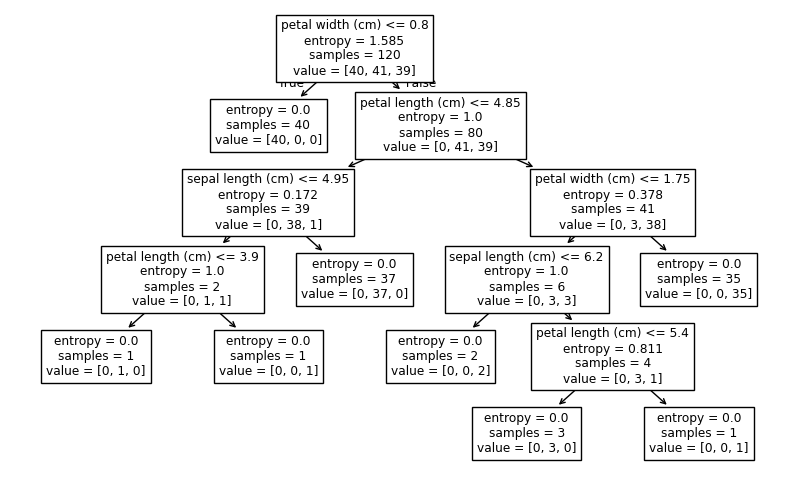

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
plot_tree(model_iris, feature_names = X_train_df.columns.to_list())

## Bosques Aleatorios (Random Forest)

**Random Forest** es un modelo de conjunto (ensemble) que combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste.

<b>Algoritmo</b>
<ul>
<li>Se construyen muchos árboles de decisión independientes.</li>
<li>Cada árbol se entrena con una muestra aleatoria de los datos (bootstrap) y una selección aleatoria de características en cada división (feature bagging).</li>
<li>Para clasificación, cada árbol vota por una clase y la clase final es la más votada (mayoría).</li>
<li>Para regresión, se promedian las predicciones de todos los árboles.</li>
</ul>

<b>Proceso de construcción:</b>
<ol>
<li>Se generan <i>N</i> subconjuntos de datos mediante muestreo con reemplazo (bootstrap).</li>
<li>Para cada subconjunto, se construye un árbol de decisión usando solo un subconjunto aleatorio de características en cada nodo.</li>
<li>Las predicciones de todos los árboles se combinan (votación o promedio).</li>
</ol>

<b>Ejemplo de aplicación:</b> Random Forest es ampliamente usado en tareas de clasificación (diagnóstico médico, detección de fraude, etc.) y regresión (predicción de precios, estimación de demanda, etc.).

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from HyAIA import HyAIA as hya

In [84]:
df = pd.read_csv("Data/diabetes.csv")

In [85]:
df_diabetes = hya(df)

In [86]:
df_diabetes.get_dqr()

,Columns_Names,Dtypes,Present_values,Missing_values,Unique_values,Max_values,Min_values
Pregnancies,Pregnancies,int64,768,0,17,17.00,0.000
Glucose,Glucose,int64,768,0,136,199.00,0.000
BloodPressure,BloodPressure,int64,768,0,47,122.00,0.000
SkinThickness,SkinThickness,int64,768,0,51,99.00,0.000
Insulin,Insulin,int64,768,0,186,846.00,0.000
BMI,BMI,float64,768,0,248,67.10,0.000
DiabetesPedigreeFunction,DiabetesPedigreeFunction,float64,768,0,517,2.42,0.078
Age,Age,int64,768,0,52,81.00,21.000
Outcome,Outcome,int64,768,0,2,1.00,0.000


In [88]:
df_diabetes.data.drop(columns='Outcome')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


#### Preprocesamiento

Tratamiento de Outliers

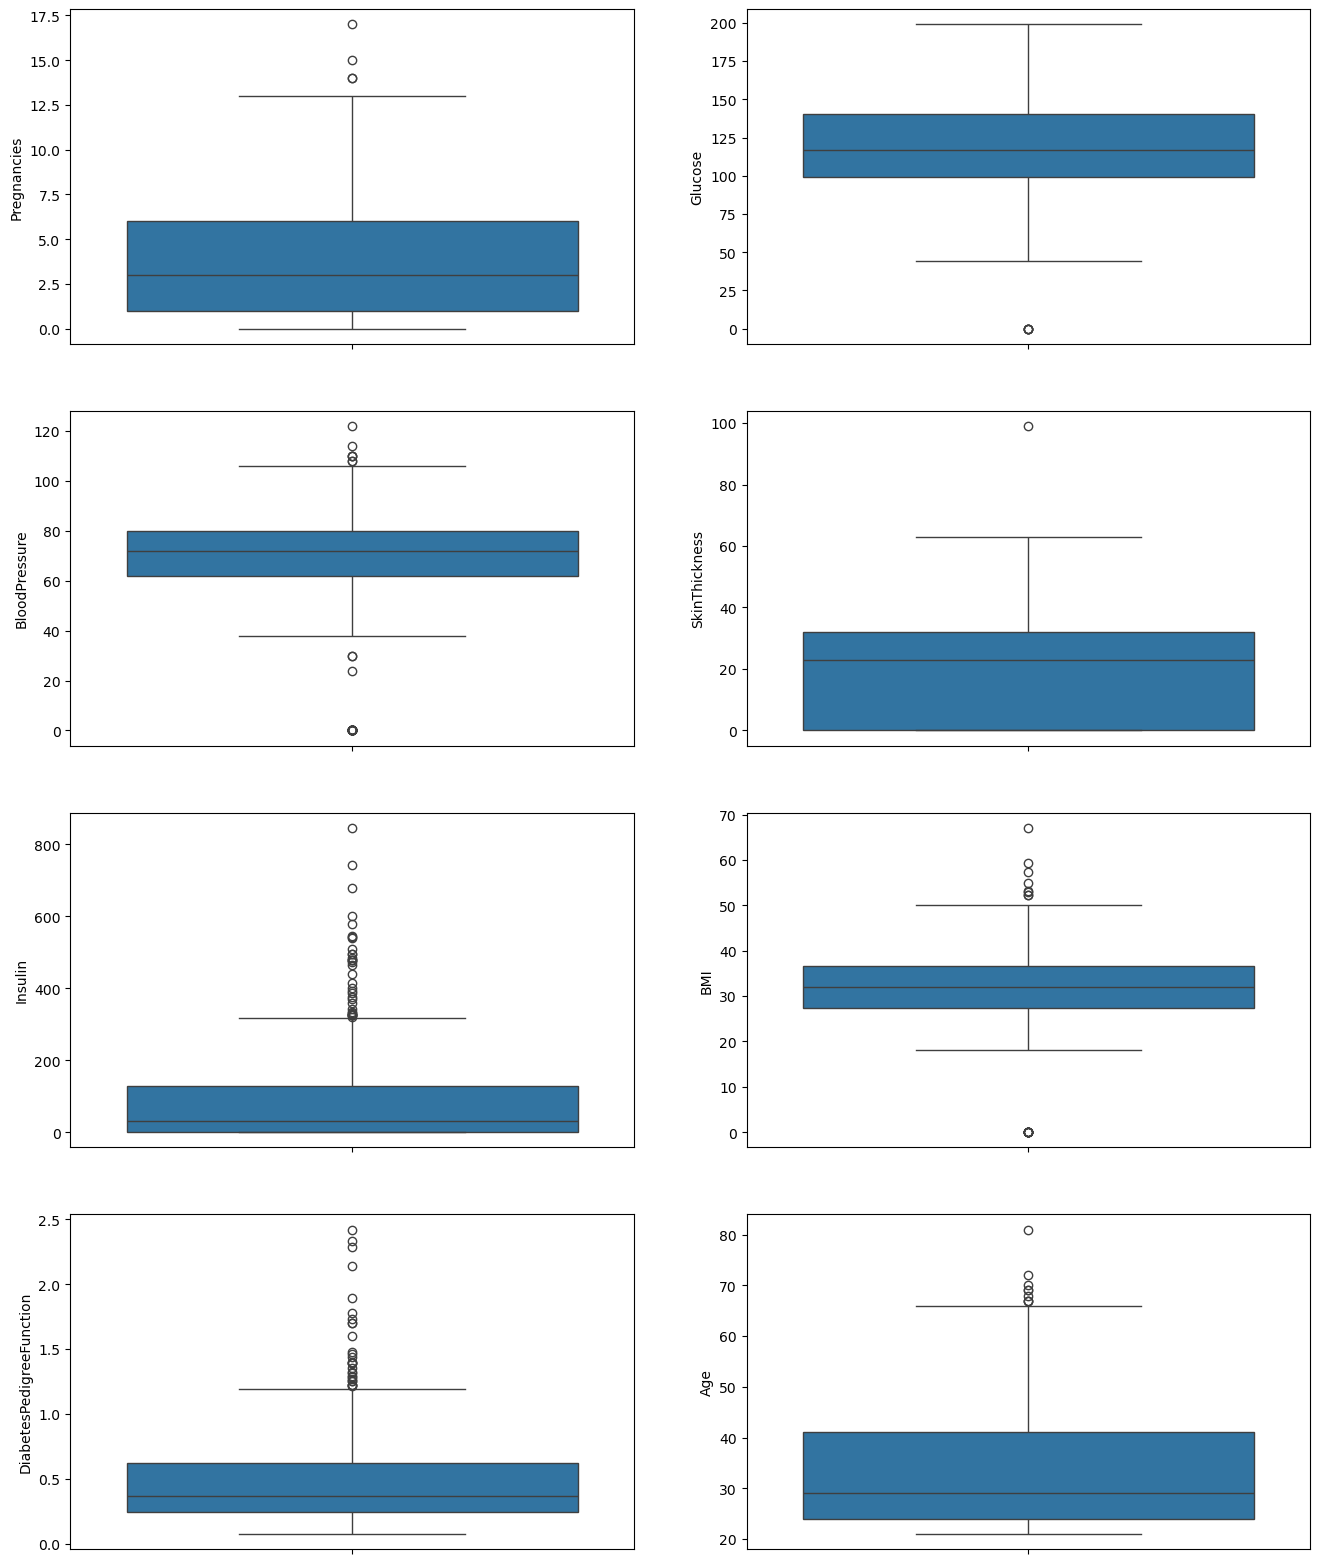

In [89]:
#Outliers
plt.figure(figsize=(16,20))
num_col = 1
for col in df_diabetes.data.drop(columns='Outcome').columns:
    plt.subplot(4,2, num_col)
    sns.boxplot(df_diabetes.data[col])
    num_col +=1

In [ ]:
# identificar los outliers 
# Obtener los ids de los outliers (método de identificación de outliers apartir del IQR)
hy.get_outliers()
hy.tratar_outliers(fetaure, método)


In [91]:
df_diabetes.data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [93]:
# Eliminando outliers (forma básica)
df_diabetes.data = df_diabetes.data[df_diabetes.data['SkinThickness']<70]
df_diabetes.data = df_diabetes.data[df_diabetes.data['Glucose']>0]
df_diabetes.data = df_diabetes.data[df_diabetes.data['BloodPressure']>35]


In [95]:
#Datos imbalanceados
df_diabetes.data['Outcome'].value_counts(normalize=True)

Outcome
0    0.657459
1    0.342541
Name: proportion, dtype: float64

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score,f1_score


In [97]:
X = df_diabetes.data.drop('Outcome', axis=1)

In [98]:
y =  df_diabetes.data['Outcome']

In [99]:
#Train test split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify=y)

In [100]:
#Función de evaluación
def metrica_de_evaluacion(model, X_train_df, y_train_df, X_test_df, y_test_df):
    y_train_pred = model.predict(X_train_df)
    y_test_pred = model.predict(X_test_df)

    print('Conjunto de testeo')
    print(f'Matriz de confusión: {confusion_matrix(y_test_pred, y_test_df)}')
    print(f'Reporte de clasificación: {classification_report(y_train_df, y_train_pred)}')

    print('Conjunto de entrenamiento')
    print(f'Matriz de confusión: {confusion_matrix(y_train_pred, y_train_df)}')
    print(f'Reporte de clasificación: {classification_report(y_train_pred, y_train_df)}')
    

#### Modelo de arbol de desición

In [101]:
#Modelo
dat_model =  DecisionTreeClassifier(class_weight = 'balanced', random_state=101)
dat_model.fit(X_train_df, y_train_df)
metrica_de_evaluacion(dat_model, X_train_df, y_train_df, X_test_df, y_test_df)


Conjunto de testeo
Matriz de confusión: [[78 20]
 [17 30]]
Reporte de clasificación:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00       198

    accuracy                           1.00       579
   macro avg       1.00      1.00      1.00       579
weighted avg       1.00      1.00      1.00       579

Conjunto de entrenamiento
Matriz de confusión: [[381   0]
 [  0 198]]
Reporte de clasificación:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00       198

    accuracy                           1.00       579
   macro avg       1.00      1.00      1.00       579
weighted avg       1.00      1.00      1.00       579



#### Modelo de Arboles Aleatorios

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [103]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |
 |  A random forest classifier.
 |
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeClassifier`.
 |  The sub-sample size is controlled with the `max_samples` parameter i

In [104]:
rf_model = RandomForestClassifier(class_weight = 'balanced', random_state=101)
rf_model.fit(X_train_df, y_train_df) 
metrica_de_evaluacion(rf_model, X_train_df, y_train_df, X_test_df, y_test_df)

Conjunto de testeo
Matriz de confusión: [[84 21]
 [11 29]]
Reporte de clasificación:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00       198

    accuracy                           1.00       579
   macro avg       1.00      1.00      1.00       579
weighted avg       1.00      1.00      1.00       579

Conjunto de entrenamiento
Matriz de confusión: [[381   0]
 [  0 198]]
Reporte de clasificación:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       381
           1       1.00      1.00      1.00       198

    accuracy                           1.00       579
   macro avg       1.00      1.00      1.00       579
weighted avg       1.00      1.00      1.00       579



<b>Resumen:</b>
<ul>
<li>Reduce el riesgo de sobreajuste que tienen los árboles individuales.</li>
<li>Generaliza mejor en datos nuevos.</li>
<li>Puede manejar grandes cantidades de variables y datos.</li>
<li>Permite estimar la importancia de cada variable.</li>
</ul>

<b>algunas desventajas:</b>
<ul>
<li>Menos interpretable que un solo árbol de decisión.</li>
<li>Puede ser más lento en entrenamiento y predicción si el número de árboles es grande.</li>
</ul>
